## Dataset Notes

common_player_info

draft_combine_stats

draft_history

game

game_info

game_summary

inactive_players

line_score

officials

other_stats

play_by_play

player

team

team_details

team_history

team_info_common

Join the greatest 75 players from the *common_player_info* table with the *draft_combine_stats* table using the __player-id__ attribute, in order to compare various statistics like height, weight and speed with the average values of the players not among the greatest 75. - NOT GOING TO WORK

In *play_by_play* table, change values of "TIE" in __scoremargin__ attribute to 0 or zero. - DONE

team_info_common useless table - DONE

team_history until 2019

team_details table can be compared with team_history table and team table

player table has 4815 rows

play_by_play table, keep period, scoremargin and video_available_flag - DONE

other_stats table can be analyzed on its own

officials table useless table - DONE

line_score table can be analyzed on its own, maybe with other_stats table

inactive_players can be joined with common_player_info and analyzed

game_summary useless table on its own, can be combined with game_info table to analyze attendance of games and by team name

game table can be analyzed for various stats

draft_history table is from 1959-1989, can compare various player stats with their overall_pick in the draft

maybe compare player_profile_flag with overall_pick

draft_combine_stats is only for the 2022 season, maybe can compare height and weight of players, as well as position

common_player_info, can compare countries and schools, with height and weight, and position

can compare years active as well

## Imports

In [168]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.patches as mpatches

#### Constants

In [80]:
cnx = sqlite3.connect('../../nba_dataset/archive/nba.sqlite')

## NBA PLAYER ANALYSIS AND VISUALIZATIONS

In [81]:
all_player_stats = pd.read_sql_query("""select person_id, display_first_last, from_year, to_year, height, weight from common_player_info""",
cnx, index_col="person_id", dtype={'person_id': 'string'})
all_player_stats

,display_first_last,from_year,to_year,height,weight
person_id,,,,,
76005,Tom Abernethy,1976.0,1980.0,6-7,220
76006,Forest Able,1956.0,1956.0,6-3,180
76007,John Abramovic,1946.0,1947.0,6-3,195
203518,Alex Abrines,2016.0,2018.0,6-6,200
1630173,Precious Achiuwa,2020.0,2022.0,6-8,225
...,...,...,...,...,...
1627757,Stephen Zimmerman,2016.0,2016.0,7-0,240
1627835,Paul Zipser,2016.0,2017.0,6-8,226
78647,Jim Zoet,1982.0,1982.0,7-1,240


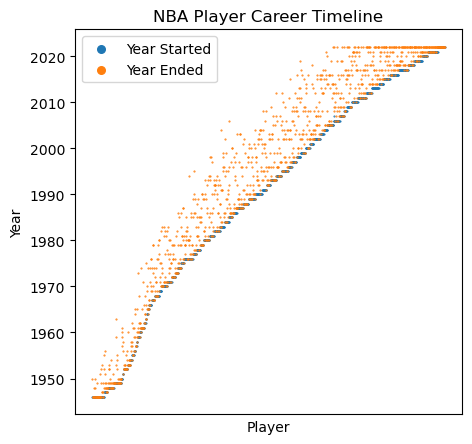

In [82]:
ax = plt.subplot()

player_years_df = all_player_stats[['display_first_last', 'from_year', 'to_year']].sort_values('from_year')

from_year_series = player_years_df['from_year'].to_numpy()
to_year_series = player_years_df['to_year'].to_numpy()
player_name_series = player_years_df['display_first_last'].to_numpy()

line1 = ax.scatter(x=player_name_series, y=from_year_series, label='Year Started', s=0.25)
line2 = ax.scatter(x=player_name_series, y=to_year_series, label='Year Ended', s=0.25)

ax.legend(handles=[line1, line2])
legend = ax.legend(frameon=True)
for legend_handle in legend.legend_handles:
    legend_handle._sizes = [30]

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.xticks(rotation=45, ha='right');

ax.set_title('NBA Player Career Timeline')

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel('Player')
ax.set_ylabel('Year');

In [83]:
player_stats = pd.read_sql_query("""select height, weight, from_year, to_year, display_first_last, game_id, player_id
                                 from common_player_info cpi join inactive_players ip on cpi.person_id = ip.player_id;""",
cnx, index_col="player_id", dtype={'game_id': 'string', 'player_id': 'string'})
player_stats

,height,weight,from_year,to_year,display_first_last,game_id
player_id,,,,,,
203518,6-6,200,2016.0,2018.0,Alex Abrines,0021600740
203518,6-6,200,2016.0,2018.0,Alex Abrines,0021600750
203518,6-6,200,2016.0,2018.0,Alex Abrines,0021601167
203518,6-6,200,2016.0,2018.0,Alex Abrines,0021601186
203518,6-6,200,2016.0,2018.0,Alex Abrines,0021601198
...,...,...,...,...,...,...
1627826,7-0,240,2016.0,2022.0,Ivica Zubac,0022200427
1627826,7-0,240,2016.0,2022.0,Ivica Zubac,0022200438
1627826,7-0,240,2016.0,2022.0,Ivica Zubac,0022200902


In [84]:
player_name_separate = player_stats.copy()
player_name_separate = (
    player_name_separate[['display_first_last']]
                        .reset_index()
                        .drop_duplicates(subset=['player_id'])
                        .set_index('player_id')
                        )
player_name_separate

,display_first_last
player_id,
203518,Alex Abrines
1630173,Precious Achiuwa
203112,Quincy Acy
1629121,Jaylen Adams
203500,Steven Adams
...,...
203469,Cody Zeller
678,George Zidek
1627757,Stephen Zimmerman


In [85]:
(player_name_separate
 .join(player_stats[['game_id', 'display_first_last']]
       .reset_index()
       .groupby('player_id')
       .size()
       .to_frame('Number of games played'))
 .sort_values('Number of games played', ascending=False)
)

,display_first_last,Number of games played
player_id,,
202322,John Wall,279
2760,Anderson Varejao,260
202347,Quincy Pondexter,239
2397,Yao Ming,239
689,Theo Ratliff,223
...,...,...
42,Monty Williams,1
1629341,Tarik Phillip,1
281,Scott Williams,1


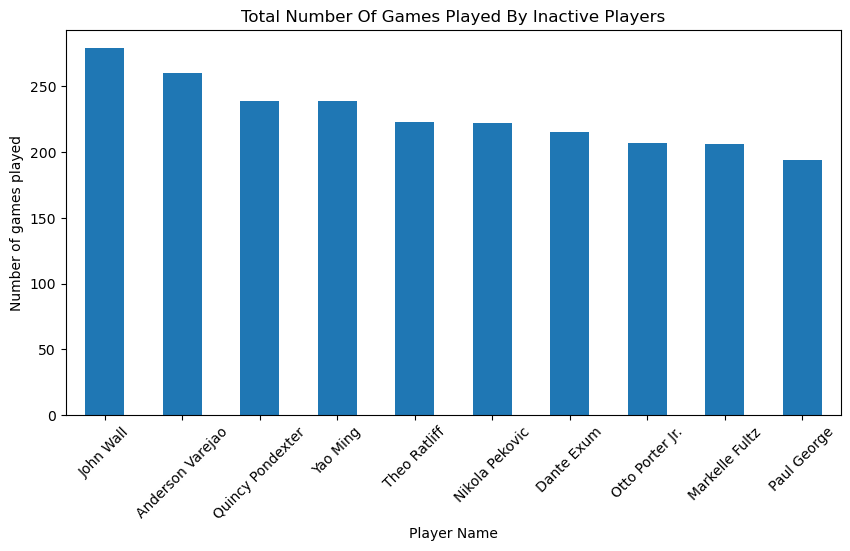

In [86]:
(player_name_separate
 .join(player_stats[['game_id', 'display_first_last']]
       .reset_index()
       .groupby('player_id')
       .size()
       .to_frame('Number of games played'))
 .nlargest(10, 'Number of games played')
).plot.bar(x='display_first_last', rot=45, figsize=(10,5), xlabel="Player Name", ylabel="Number of games played",
           title="Total number of games played by inactive players".title(), legend=False);

## NBA TEAM ANALYSIS AND VISUALIZATIONS

In [87]:
team_stats = pd.read_sql_query("""
                               select th.team_id, th.city, th.nickname, (th.city || ' ' || th.nickname) as "full_name", 
                               th.year_founded, year_active_till, arena, arenacapacity from team t join team_history th on t.id = th.team_id
                               left join team_details td on (th.city || ' ' || th.nickname) = (td.city || ' ' || td.nickname);
                               """,
cnx, index_col="team_id", dtype={'team_id': 'string'})
team_stats.head()

,city,nickname,full_name,year_founded,year_active_till,arena,arenacapacity
team_id,,,,,,,
1610612737,Atlanta,Hawks,Atlanta Hawks,1968,2019,State Farm Arena,18729.0
1610612737,Milwaukee,Hawks,Milwaukee Hawks,1951,1954,None,NaN
1610612737,St. Louis,Hawks,St. Louis Hawks,1955,1967,None,NaN
1610612737,Tri-Cities,Blackhawks,Tri-Cities Blackhawks,1949,1950,None,NaN
1610612738,Boston,Celtics,Boston Celtics,1946,2019,TD Garden,18624.0


In [88]:
team_stats.reset_index().sort_values(['team_id', 'year_founded'])

,team_id,city,nickname,full_name,year_founded,year_active_till,arena,arenacapacity
3,1610612737,Tri-Cities,Blackhawks,Tri-Cities Blackhawks,1949,1950,None,NaN
1,1610612737,Milwaukee,Hawks,Milwaukee Hawks,1951,1954,None,NaN
2,1610612737,St. Louis,Hawks,St. Louis Hawks,1955,1967,None,NaN
0,1610612737,Atlanta,Hawks,Atlanta Hawks,1968,2019,State Farm Arena,18729.0
4,1610612738,Boston,Celtics,Boston Celtics,1946,2019,TD Garden,18624.0
5,1610612740,New Orleans,Hornets,New Orleans Hornets,2002,2004,None,NaN
8,1610612740,New Orleans/Oklahoma City,Hornets,New Orleans/Oklahoma City Hornets,2005,2006,None,NaN
6,1610612740,New Orleans,Hornets,New Orleans Hornets,2007,2012,None,NaN
7,1610612740,New Orleans,Pelicans,New Orleans Pelicans,2013,2019,Smoothie King Center,NaN
9,1610612741,Chicago,Bulls,Chicago Bulls,1966,2019,United Center,21711.0


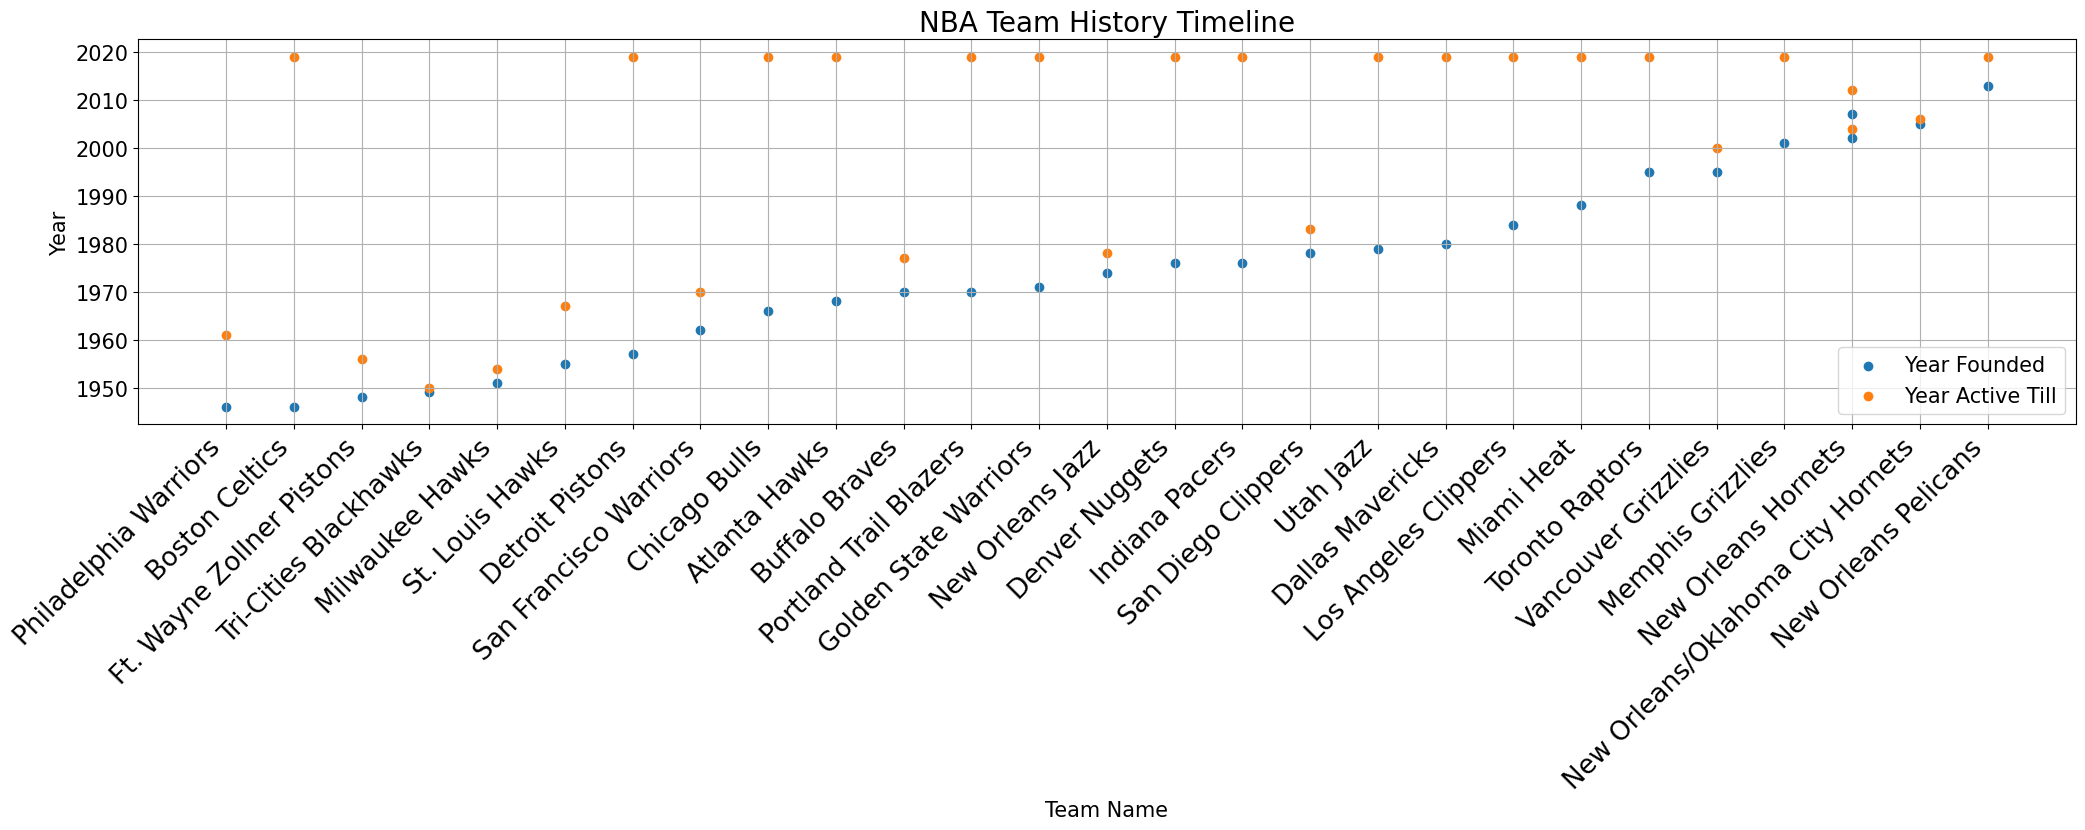

In [89]:
ax = plt.subplot()

year_founded_df = team_stats[['full_name', 'year_founded', 'year_active_till']].sort_values('year_founded')

year_founded_series = year_founded_df['year_founded'].to_numpy()
year_active_till_series = year_founded_df['year_active_till'].to_numpy()
team_name_series = year_founded_df['full_name'].to_numpy()

line1 = ax.scatter(x=team_name_series, y=year_founded_series, label='Year Founded')
line2 = ax.scatter(x=team_name_series, y=year_active_till_series, label='Year Active Till')

ax.legend(handles=[line1, line2], fontsize=15)

fig = plt.gcf()
fig.set_size_inches(25, 5)
plt.xticks(rotation=45, ha='right')

ax.set_title('NBA Team History Timeline', fontsize=20)
ax.set_xlabel('Team Name', fontsize=15)
ax.set_ylabel('Year', fontsize=15)

plt.grid()

plt.xticks(fontsize=19)
plt.yticks(fontsize=15);

## NBA GAME ANALYSIS AND VISUALIZATIONS

In [90]:
play_by_play = pd.read_sql_query("""select game_id, period, scoremargin, video_available_flag, wl_home, official_id,
                                 (first_name || ' ' || last_name) as "official_full_name" FROM play_by_play join game using(game_id)
                                 left join officials using(game_id);""",
                                 cnx, index_col="game_id", dtype={'game_id': 'string'})
play_by_play

,period,scoremargin,video_available_flag,wl_home,official_id,official_full_name
game_id,,,,,,
0029600009,1,None,0,W,None,None
0029600009,1,None,0,W,None,None
0029600009,1,None,0,W,None,None
0029600009,1,None,0,W,None,None
0029600009,1,None,0,W,None,None
...,...,...,...,...,...,...
0022201014,4,None,1,L,1628951,John Butler
0022201014,4,None,1,L,2530,Ed Malloy
0022201014,4,-2,1,L,101283,Brian Forte


In [91]:
play_by_play = play_by_play.dropna(subset='scoremargin')

In [93]:
play_by_play.columns

Index(['period', 'scoremargin', 'video_available_flag', 'wl_home',
       'official_id', 'official_full_name'],
      dtype='object')

In [220]:
nba_df_copy = play_by_play.copy()

In [171]:
score_margin = nba_df_copy['scoremargin'].copy()

In [172]:
score_margin = score_margin.replace({'TIE': 0})
score_margin

game_id
0029600009     2
0029600009     0
0029600009     2
0029600009     0
0029600009    -2
              ..
0022201014    -2
0022201014    -2
0022201014    -2
0022201014    -2
0022201014    -2
Name: scoremargin, Length: 8585887, dtype: object

In [221]:
nba_df_copy['scoremargin'] = score_margin

In [223]:
nba_df_copy = nba_df_copy.astype({'scoremargin': 'int64'})

In [230]:
nba_df_copy['video_available_flag'] = nba_df_copy['video_available_flag'].map({"1": True, "0": False})

In [126]:
nba_df_copy = nba_df_copy.convert_dtypes()

In [127]:
nba_df_copy.dtypes

period                           Int64
scoremargin                      Int64
video_available_flag           boolean
wl_home                 string[python]
official_id             string[python]
official_full_name      string[python]
dtype: object

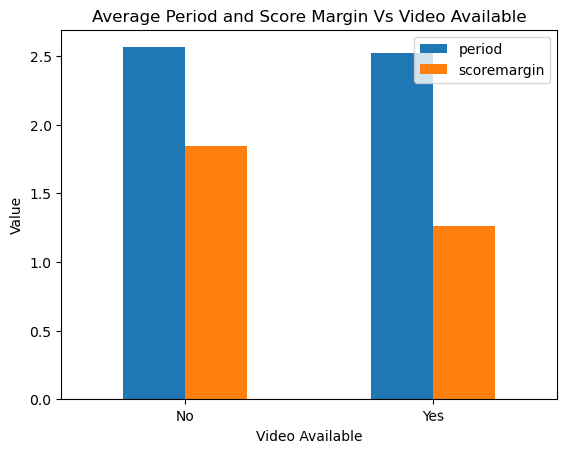

In [234]:
(nba_df_copy
    .groupby('video_available_flag')
    .mean(numeric_only=True)
    .rename(index={True: 'Yes', False: 'No'})
    .plot
    .bar(title="Average Period and Score Margin Vs Video Available", rot=1, ylabel="Value", xlabel="Video Available")
);

In [129]:
def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s

y_format = tkr.FuncFormatter(func)  # make formatter

In [130]:
import numpy as np

def mirrored(maxval, inc=1):
    x = np.arange(inc, maxval, inc)
    if x[-1] != maxval:
        x = np.r_[x, maxval]
    return np.r_[-x[::-1], 0, x]

In [131]:
def bins_labels(bins, **kwargs):
    bin_w = mirrored(max(abs(min(bins)), abs(max(bins))), 5)
    plt.xticks(bin_w, bin_w, **kwargs)
    plt.xlim(bins.min(), bins.max())

In [132]:
def plot_scoremargin_histogram(scoremargin_series: pd.Series, title="Total Score Margin for NBA Games"):
    n_bins = abs(scoremargin_series.max() - scoremargin_series.min())
    home_sum = abs(scoremargin_series.loc[scoremargin_series > 0].sum())
    away_sum = abs(scoremargin_series.loc[scoremargin_series < 0].sum())

    _, _, bars = plt.hist(scoremargin_series, bins=(n_bins), color="C0")

    for bar in bars:
        if bar.get_x() > 0:
            bar.set_facecolor("C1")
        elif bar.get_x() == 0:
            bar.set_facecolor("y")

    bins_labels(scoremargin_series.astype(int), fontsize=6)
    
    plt.xlabel("Score Margin")
    plt.ylabel("Frequency")
    plt.gca().yaxis.set_major_formatter(y_format)
    
    plt.text(scoremargin_series.max() / 2, plt.gca().get_ylim()[1] / 2, f'{home_sum:,}')
    plt.text(scoremargin_series.min() / 1.5, plt.gca().get_ylim()[1] / 2, f'{away_sum:,}')
    
    orange_patch = mpatches.Patch(color='C1', label='Home Team Advantage')
    blue_patch = mpatches.Patch(color='C0', label='Away Team Advantage')
    yellow_patch = mpatches.Patch(color='y', label='Tied Score')
    plt.legend(handles=[orange_patch, blue_patch, yellow_patch])
    
    plt.title(title)
    
    plt.show()

From this histogram, a prediction can be made that home teams (positive values) win NBA games more often than visitor teams (negative values)

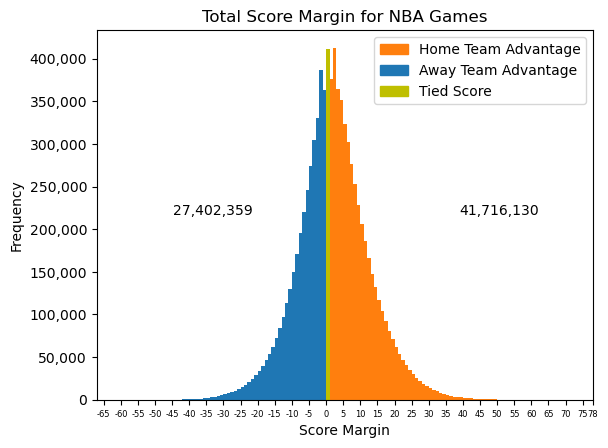

In [133]:
plot_scoremargin_histogram(nba_df_copy['scoremargin'], title="Total Score Margin for NBA Games")

Now only using the 8th period (the maximum, or last, period), a prediction can be made that visitor teams (negative values) win NBA games more often than home teams (positive values)

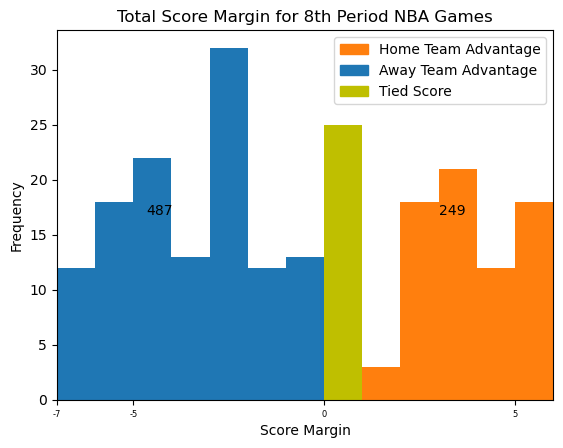

In [134]:
plot_scoremargin_histogram(nba_df_copy.loc[nba_df_copy['period'] == nba_df_copy['period'].max()]
['scoremargin'], title="Total Score Margin for 8th Period NBA Games")

In conclusion, it appears that home teams often have a higher score margin throughout the duration of the game. However, visitor teams often have a larger score margin during the last period (8) of games. Therefore, it can be predicted that visitor teams win games more often than home teams because their score margin is oftentimes higher during the last period of the game.

A caveat of this prediction, though, is that the number of score margin values during the 8th period is only 83, much less than during other periods of the game, so it is more likely that home teams win games more often than visitor teams.

In [135]:
nba_df_copy['period'].value_counts()

period
4    2184744
2    2164207
3    2137105
1    2026079
5      63333
6       8856
7       1344
8        219
Name: count, dtype: Int64

<Axes: title={'center': 'Recorded Score Margin Values Per Period'}, xlabel='Frequency', ylabel='period'>

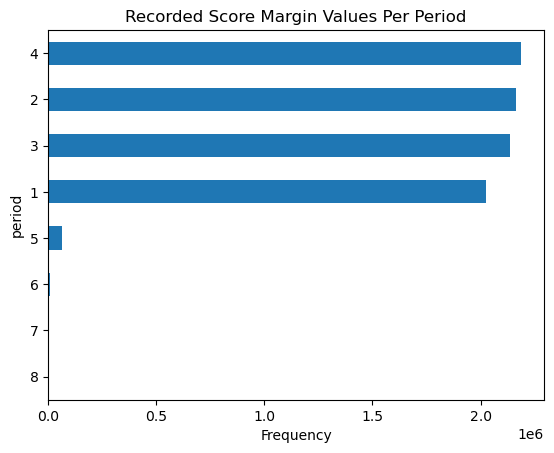

In [136]:
nba_df_copy['period'].value_counts().sort_values().plot.barh(title='Recorded Score Margin Values Per Period', xlabel="Frequency")

Examining the 4th period, which has a lot more data points than the 8th period, we can see that indeed the score margin for the home teams is greater than that of the visitor teams.

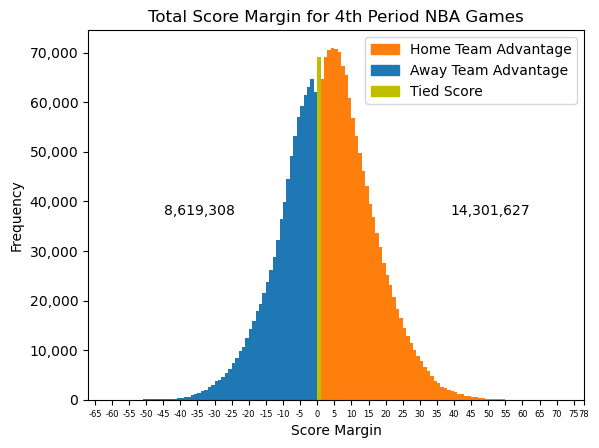

In [137]:
plot_scoremargin_histogram(nba_df_copy.loc[nba_df_copy['period'] == 4]['scoremargin'],
                           title="Total Score Margin for 4th Period NBA Games")

The assumption has been that the more often that a team has a higher score margin, then the more likely it is that they are winning more often.

However, this is simply an assumption and is not based on evidence. Therefore, we will compare scoremargin with win/loss records to see if there is validity to the above claim.

In [138]:
nba_df_wl = nba_df_copy.copy()
nba_df_wl = (
    nba_df_wl[['wl_home']]
    .reset_index()
    .drop_duplicates(subset=['game_id'])
    .sort_values('game_id')
    .set_index('game_id')
    )
nba_df_wl

,wl_home
game_id,
0020000001,L
0020000002,L
0020000003,W
0020000004,L
0020000005,L
...,...
0029901185,W
0029901186,W
0029901187,L


In [139]:
nba_scoremargin_wl = (
    nba_df_wl
    .join(nba_df_copy
          .reset_index()
          [['game_id', 'scoremargin', 'wl_home']]
          .groupby('game_id')
          .mean(numeric_only=True)
          )
    )

In [140]:
nba_scoremargin_wl

,wl_home,scoremargin
game_id,,
0020000001,L,-13.414414
0020000002,L,0.327103
0020000003,W,6.690265
0020000004,L,-10.168067
0020000005,L,-7.815126
...,...,...
0029901185,W,-2.0
0029901186,W,3.009009
0029901187,L,-1.798246


In [141]:
nba_scoremargin_wl = nba_scoremargin_wl.astype({'scoremargin': 'string'})
nba_scoremargin_wl.dtypes

wl_home        string[python]
scoremargin    string[python]
dtype: object

In [142]:
nba_scoremargin_wl['scoremargin'] = (
    nba_scoremargin_wl['scoremargin']
    .mask(nba_scoremargin_wl['scoremargin']
          .astype(float) < 0, 'L')
    .mask(nba_scoremargin_wl['scoremargin']
          .astype(float) > 0, 'W')
    )
nba_scoremargin_wl

,wl_home,scoremargin
game_id,,
0020000001,L,L
0020000002,L,W
0020000003,W,W
0020000004,L,L
0020000005,L,L
...,...,...
0029901185,W,L
0029901186,W,W
0029901187,L,L


In [143]:
nba_scoremargin_wl['scoremargin'].unique()

<StringArray>
['L', 'W', '0.0']
Length: 3, dtype: string

In [144]:
nba_scoremargin_wl.loc[nba_scoremargin_wl['scoremargin'] == '0.0']

,wl_home,scoremargin
game_id,,
0020000416,W,0.0
0020400468,L,0.0
0021000262,L,0.0
0021200794,W,0.0
0021400868,W,0.0
0021500095,W,0.0
0021600106,W,0.0
0021600515,L,0.0
0022200985,L,0.0


In [145]:
nba_scoremargin_wl['wl_home'].unique()

<StringArray>
['L', 'W', <NA>]
Length: 3, dtype: string

In [146]:
nba_scoremargin_wl = nba_scoremargin_wl.dropna(subset='wl_home')

In [147]:
nba_scoremargin_wl.loc[nba_scoremargin_wl['wl_home'].isna()]

,wl_home,scoremargin
game_id,,


In [148]:
print(f"""{round((
    len(nba_scoremargin_wl.loc[nba_scoremargin_wl['scoremargin'] != nba_scoremargin_wl['wl_home']])
    / len(nba_scoremargin_wl)) * 100)}%\
 of game results don’t reflect the average recorded score margin.""")

18% of game results don’t reflect the average recorded score margin.


In [149]:
print(f"""Home teams have won \
{round((
len(nba_scoremargin_wl.loc[nba_scoremargin_wl['wl_home'] == 'W'])
/ len(nba_scoremargin_wl)) * 100)}% of the time.""")

print(f"""Home teams have had an average score margin advantage \
{round((len(nba_scoremargin_wl.loc[nba_scoremargin_wl['scoremargin'] == 'W'])
/ len(nba_scoremargin_wl)) * 100)}% of the time.""")

Home teams have won 59% of the time.
Home teams have had an average score margin advantage 58% of the time.


### EXPORTING TO CSV FOR TABLEAU VISUALIZATIONS